In [3]:
#%matplotlib inline
import pandas as pd
import numpy as np
#from fbprophet import Prophet
import math
import vertica_python
import os
import getpass;
%matplotlib inline
import seaborn as sns

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
password = getpass.getpass('password: ')

password: ········


In [6]:
# username = os.getenv('VERTICA_USERNAME')
# password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': 'ahemphill',
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [7]:
p_verify_positive_query = """

select * 
from ahemphill.p_verify_model_master
where date >= '2017-01-01'
AND has_verified = 1
AND cumulative_is_active > 0
ORDER BY RANDOMINT(200000)
LIMIT 200000

"""
    
p_verify_negative_query = """

select * 
from ahemphill.p_verify_model_master
where date >= '2017-01-01'
AND has_verified = 0
AND cumulative_is_active > 0
ORDER BY RANDOMINT(200000)
LIMIT 100000

"""

    
p_verify_overall_query = """

select * 
from ahemphill.p_verify_model_master
where date >= '2017-01-01'
ORDER BY RANDOMINT(200000)
LIMIT 100000

"""

In [102]:
p_verify_eval_query = """

SELECT
	*
FROM
	ahemphill.p_verify_model_master_last_day
WHERE
	latest_date >= CURRENT_DATE()-7

"""

In [118]:
p_verify_baseline_query = """

SELECT
	*
FROM
	ahemphill.p_verify_model_master_last_day
WHERE
	latest_date BETWEEN '2017-07-01' AND '2017-07-08'

"""

In [8]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(p_verify_positive_query)
extract = cur.fetchall()
df_positive = pd.DataFrame(extract)

cur.execute(p_verify_negative_query)
extract = cur.fetchall()
df_negative = pd.DataFrame(extract)

connection.close()

In [122]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(p_verify_eval_query)
extract = cur.fetchall()
df_eval = pd.DataFrame(extract)

connection.close()

In [123]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(p_verify_baseline_query)
extract = cur.fetchall()
df_baseline = pd.DataFrame(extract)

connection.close()

In [125]:
df_eval.shape

(388221, 50)

In [126]:
df_baseline.shape

(152835, 50)

In [10]:
df = pd.concat([df_positive, df_negative])

In [17]:
df.head()

,date,user_id,course_id,week,is_active,cnt_active_activity,is_engaged,cnt_engaged_activity,is_engaged_video,cnt_video_activity,...,cumulative_is_active,cumulative_cnt_active_activity,cumulative_is_engaged,cumulative_cnt_engaged_activity,cumulative_is_engaged_video,cumulative_cnt_video_activity,cumulative_is_engaged_problem,cumulative_cnt_problem_activity,cumulative_is_engaged_forum,cumulative_cnt_forum_activity
0,2017-07-09,13920424,course-v1:Microsoft+DAT205x+3T2016,week_1,1,547,1,22,1,15,...,4,2423,4,128,4,41,4,87,0,0
1,2017-03-02,7210192,course-v1:ColumbiaX+DS101X+1T2016,week_1,1,5,0,0,0,0,...,1,5,0,0,0,0,0,0,0,0
2,2017-02-22,102424,course-v1:Microsoft+DEV204x+1T2017,week_1,1,1,0,0,0,0,...,3,429,2,26,2,18,1,7,1,1
3,2017-06-26,13237749,course-v1:Microsoft+DAT203.3x+2T2017,week_2,1,494,1,74,1,60,...,7,1411,5,207,3,185,5,22,0,0
4,2017-02-21,9896276,course-v1:IDBx+IDB6.1x+1T2017,week_1,1,31,0,0,0,0,...,1,31,0,0,0,0,0,0,0,0


In [12]:
df.sum()['has_verified']

72667.0

In [47]:
categorical_columns = [
    'pacing_type',
    'course_subject',
#     'course_partner',
    'level_type',
#     'user_last_location_country_code',
    'user_level_of_education',
    'user_gender',
    'course_seat_price',
    'course_run_number',
    'year_registered'
]

numeric_columns = [
    
'is_active',
'cnt_active_activity',
'is_engaged',
'cnt_engaged_activity',
'is_engaged_video',
'cnt_video_activity',
'is_engaged_problem',
'cnt_problem_activity',
'is_engaged_forum',
'cnt_forum_activity',
'days_until_verification_deadline',
'cum_sum_course_vtr',
'days_until_verification_deadline',
'days_from_content_availability',
'cnt_prior_enrolls',
'cnt_2017_enrolls',
'cnt_2016_enrolls',
'cnt_2015_enrolls',
'cnt_prior_verifs',
'cnt_2017_verifs',
'cnt_2016_verifs',
'cnt_2015_verifs',
'cnt_prior_passes',
'cumulative_is_active',
'cumulative_cnt_active_activity',
'cumulative_is_engaged',
'cumulative_cnt_engaged_activity',
'cumulative_is_engaged_video',
'cumulative_cnt_video_activity',
'cumulative_is_engaged_problem',
'cumulative_cnt_problem_activity',
'cumulative_is_engaged_forum',
'cumulative_cnt_forum_activity' 
]

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [20]:
def new_model(df, model_type='rf'):
    
    X = pd.get_dummies(df[categorical_columns])
    
    for i in numeric_columns:
        X[i] = df[i]
    
    X = X.fillna(-1)

    y = df['has_verified']

    if (model_type=='rf'):
        model = RandomForestClassifier(n_estimators = 100)
    elif (model_type=='gbdt'):
        model = GradientBoostingClassifier()
    
    return X, y, model

In [21]:
def train_and_evaluate_model(X, y, model):
    
    ## split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
    
    ## fit model
    model.fit(X_train, y_train)
    
    #print ('Model score: %f \n' % model.score(X_test, y_test))
    
    ## predict result on holdout
    y_test_predicted = model.predict(X_test)
    
    ## understand how well each class is predicted
    print ('Confusion matrix \n ************')
    print (confusion_matrix(y_test, model.predict(X_test)))
    
    print ("Precision is: %f\n" % metrics.precision_score(y_test, y_test_predicted))
    print ("Recall is: %f\n" % metrics.recall_score(y_test, y_test_predicted))
    
    ## understand top features of model
    top_features_list = model.feature_importances_.argsort()[::-1][:20]
    
    for i in top_features_list:
        print (X.columns[i], model.feature_importances_[i])
    
    ## construct prediction probabilities for ROC curve
    pred_y_test = model.predict_proba(X_test)

    pred_prob_verified = []
    
    for i in pred_y_test:
        pred_prob_verified.append(i[1])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob_verified, pos_label = 1)
    
    metrics.auc(fpr, tpr)
    
    ax = sns.regplot(
    x = fpr,
    y = tpr,
    fit_reg = False
    )

    ax.set(
        title = 'ROC',
        xlabel = 'FPR',
        ylabel = 'TPR'
    )

Confusion matrix 
 ************
[[21270  3799]
 [ 4924 13174]]
Precision is: 0.776174

Recall is: 0.727926

('cumulative_cnt_active_activity', 0.13721101696152663)
('cnt_prior_verifs', 0.09739920812001418)
(u'course_seat_price', 0.065219916915968568)
(u'course_run_number', 0.05044719057959262)
('cumulative_cnt_engaged_activity', 0.046363716901766681)
('cnt_prior_enrolls', 0.044741575942242706)
('cumulative_cnt_video_activity', 0.040767287449404194)
('cumulative_cnt_problem_activity', 0.040686175853849378)
('cnt_2017_enrolls', 0.036853886968211957)
('cumulative_is_active', 0.033873591698578912)
('cnt_2016_enrolls', 0.030680324945385803)
('cnt_prior_passes', 0.028604315540531708)
(u'year_registered', 0.022493475067030679)
('cumulative_is_engaged_problem', 0.018608876525225776)
('cnt_2015_enrolls', 0.016841997038311445)
('cumulative_is_engaged', 0.015162109593167503)
('cnt_2016_verifs', 0.01444602334587611)
('cnt_2017_verifs', 0.014170674615738439)
('cumulative_is_engaged_video', 0.014158

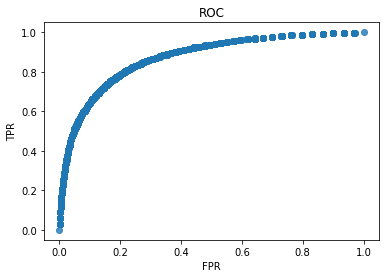

In [48]:
X, y, model = new_model(df, 'rf')
train_and_evaluate_model(X, y, model)

## Train on skewed sample (^^^), evaluate on actual sample...

In [127]:
X_eval = pd.get_dummies(df_eval[categorical_columns])

for i in numeric_columns:
    X_eval[i] = df_eval[i]

X_eval = X_eval.fillna(-1)

y_eval = df_eval['has_verified']

In [128]:
X.shape

(172667, 72)

In [129]:
X_eval[X.columns.tolist()].shape

(388221, 72)

In [130]:
X_eval = X_eval[X.columns.tolist()]

Confusion matrix 
 ************
[[334128  52968]
 [   362    763]]
Precision is: 0.014200

Recall is: 0.678222



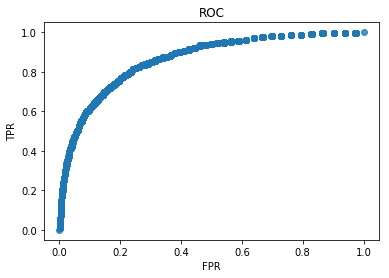

In [131]:


## split train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## fit model
#model.fit(X_train, y_train)

#print ('Model score: %f \n' % model.score(X_test, y_test))

## predict result on holdout
y_eval_predicted = model.predict(X_eval)

## understand how well each class is predicted
print ('Confusion matrix \n ************')
print (confusion_matrix(y_eval, y_eval_predicted))

print ("Precision is: %f\n" % metrics.precision_score(y_eval, y_eval_predicted))
print ("Recall is: %f\n" % metrics.recall_score(y_eval, y_eval_predicted))

## construct prediction probabilities for ROC curve
pred_y_eval = model.predict_proba(X_eval)

pred_prob_verified = []

for i in pred_y_eval:
    pred_prob_verified.append(i[1])

fpr, tpr, thresholds = metrics.roc_curve(y_eval, pred_prob_verified, pos_label = 1)

metrics.auc(fpr, tpr)

ax = sns.regplot(
x = fpr,
y = tpr,
fit_reg = False
)

ax.set(
    title = 'ROC',
    xlabel = 'FPR',
    ylabel = 'TPR'
)

In [132]:
pred_prob_verified_round = [round(i,1) for i in pred_prob_verified]

In [133]:
df_eval['pred_prob'] = pred_prob_verified_round

In [134]:
df_eval.head()

,latest_date,user_id,course_id,is_active,cnt_active_activity,is_engaged,cnt_engaged_activity,is_engaged_video,cnt_video_activity,is_engaged_problem,...,cumulative_cnt_active_activity,cumulative_is_engaged,cumulative_cnt_engaged_activity,cumulative_is_engaged_video,cumulative_cnt_video_activity,cumulative_is_engaged_problem,cumulative_cnt_problem_activity,cumulative_is_engaged_forum,cumulative_cnt_forum_activity,pred_prob
0,2017-08-22,7808344,course-v1:Microsoft+DAT205x+3T2017,0,0,0,0,0,0,0,...,64,1,4,1,3,1,1,0,0,0.3
1,2017-08-22,7808428,course-v1:ETSx+TOEFLx+3T2017,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0.0
2,2017-08-22,7808428,course-v1:KyotoUx+009x+2T2017,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0.0
3,2017-08-22,7808428,course-v1:UQx+IELTSx+2T2017,0,0,0,0,0,0,0,...,31,0,0,0,0,0,0,0,0,0.0
4,2017-08-22,7808428,course-v1:UQx+Write101x+2T2017,0,0,0,0,0,0,0,...,11,0,0,0,0,0,0,0,0,0.0


In [160]:
df_eval[df_eval['has_verified']==0].groupby('pred_prob').count()['user_id']

pred_prob
0.0     66288
0.1    119268
0.2     60279
0.3     47145
0.4     27406
0.5     22397
0.6     16399
0.7     12504
0.8      9092
0.9      4760
1.0      1558
Name: user_id, dtype: int64

In [161]:
df_eval[['latest_date','user_id','course_id','has_verified','pred_prob']].to_csv('./eval.csv', index = False)

## Measure baseline behavior
* * *

In [136]:
X_baseline = pd.get_dummies(df_baseline[categorical_columns])

for i in numeric_columns:
    X_baseline[i] = df_baseline[i]

X_baseline = X_baseline.fillna(-1)

y_baseline = df_baseline['has_verified']

In [137]:
X.shape

(172667, 72)

In [138]:
X_baseline[X.columns.tolist()].shape

(152835, 72)

In [139]:
X_baseline = X_baseline[X.columns.tolist()]

Confusion matrix 
 ************
[[334128  52968]
 [   362    763]]
Precision is: 0.100140

Recall is: 0.930086



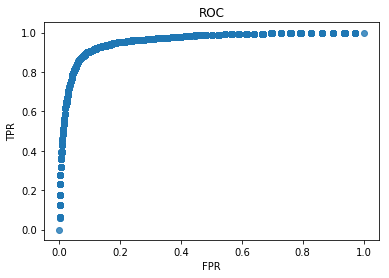

In [140]:
## split train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## fit model
#model.fit(X_train, y_train)

#print ('Model score: %f \n' % model.score(X_test, y_test))

## predict result on holdout
y_baseline_predicted = model.predict(X_baseline)

## understand how well each class is predicted
print ('Confusion matrix \n ************')
print (confusion_matrix(y_eval, y_eval_predicted))

print ("Precision is: %f\n" % metrics.precision_score(y_baseline, y_baseline_predicted))
print ("Recall is: %f\n" % metrics.recall_score(y_baseline, y_baseline_predicted))

## construct prediction probabilities for ROC curve
pred_y_baseline = model.predict_proba(X_baseline)

pred_prob_verified = []

for i in pred_y_baseline:
    pred_prob_verified.append(i[1])

fpr, tpr, thresholds = metrics.roc_curve(y_baseline, pred_prob_verified, pos_label = 1)

metrics.auc(fpr, tpr)

ax = sns.regplot(
x = fpr,
y = tpr,
fit_reg = False
)

ax.set(
    title = 'ROC',
    xlabel = 'FPR',
    ylabel = 'TPR'
)

In [141]:
pred_prob_verified_round = [round(i,1) for i in pred_prob_verified]
df_baseline['pred_prob'] = pred_prob_verified_round

In [157]:
df_baseline.shape

(152835, 51)

In [159]:
df_baseline[['latest_date','user_id','course_id','has_verified','pred_prob']].to_csv('./baseline.csv', index = False)

In [154]:
write_query = """

--CREATE FLEX TABLE ahemphill.baseline();

COPY ahemphill.baseline FROM LOCAL '/home/ubuntu/baseline.csv' WITH DELIMITER ',';

"""

In [155]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(write_query)
extract = cur.fetchall()

connection.close()

KeyError: 'F'

* * *
* * *

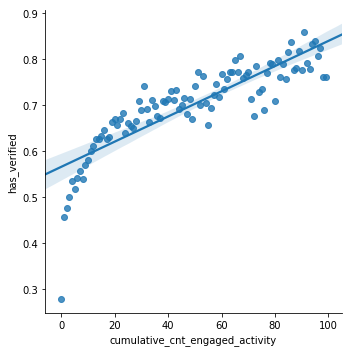

In [96]:
temp = temp = df.groupby('cumulative_cnt_engaged_activity').sum()['has_verified']/df.groupby('cumulative_cnt_engaged_activity').count()['has_verified']

sns.lmplot(
    data = temp.reset_index()[temp.reset_index()['cumulative_cnt_engaged_activity'] < 100],
    x = 'cumulative_cnt_engaged_activity', 
    y = 'has_verified'
)

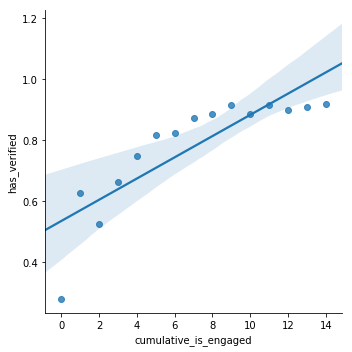

In [97]:
temp = df.groupby('cumulative_is_engaged').sum()['has_verified']/df.groupby('cumulative_is_engaged').count()['has_verified']
sns.lmplot(
    data = temp.reset_index(),
    x = 'cumulative_is_engaged', 
    y = 'has_verified'
)

In [33]:
from tpot import TPOTRegressor, TPOTClassifier

In [ ]:
# tpot = TPOTClassifier(generations = 5,
#                      verbosity=2,
#                      n_jobs=4,
#                     config_dict='TPOT light',
#                       scoring = 'recall'
#                     )

# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export('tpot_exported_pipeline_p_verify.py')

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]Process PoolWorker-3:
Process PoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 362, in get
    task = get()
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
    return r